# Analysis

## Data Overview

The dataset represents records of patients(users) with suspected diabetes. The data contains: user personal data(personal_train) and user health data(other_train).

The actual presence of the disease in the user was evaluated by an independent test. This is stored in the "class" column and we consider it guaranteed to be true.

Attributes:
 - Aggregated blood sugar measurement results using 4 different metrics
 - Aggregated blood oxygen measurement results using 4 different metrics
 - User information such as age, date of birth, highest level of education, type of employment, marital status, gender, country of birth, income and weekly workload.
 - Dependent attribute(class) indicating the actual presence of the disease

# Table of Content

[First look at the data - other_train](#first_other_train)

[First look at the data - personal_train](#first_personal_train)

[One by one analysis (continuous) - other_train](#second_other_train)

[One by one analysis (categorical) - other_train](#third_other_train)

[One by one analysis (continuous) - personal_train](#second_personal_train)

[One by one analysis (categorical) - personal_train](#third_personal_train)

[Pair analysis - continuous](#pair_analysis_continuous)

[Pair analysis - continuous&categorical](#pair_analysis_continuous_categorical)

[Pair analysis - categorical&categorical](#pair_analysis_categorical_categorical)

[Hypotesis](#hypotesis)
 - [1. A person who has high skewness_glucose values ​​has a greater chance of suffering from the disease](#hypotesis_1)
 - [2. When a person has higher mean_oxygen value, he may not have a disease](#hypotesis_2)

[The problem in the data](#data_problem)

[Assumptions of solution](#assumptions)

In [1]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

## First look at the data - other_train <a id='first_other_train'></a>

In [2]:
other_train = pd.read_csv('data/other_train.csv')
other_train.head()

Unnamed: 0.1  Unnamed: 0   name   address  kurtosis_oxygen pregnant  \
0             0           0  user0  address0        16.152882        f   
1             1           1  user1  address1         9.057714        f   
2             2           2  user2  address2        -0.799085        f   
3             3           3  user3  address3        11.153594        f   
4             4           4  user4  address4         0.905511        f   

   education-num    relationship  skewness_glucose  mean_glucose  ...  \
0            9.0         Husband          0.179927    128.781250  ...   
1           14.0         Husband         -0.059664    118.500000  ...   
2           16.0            Wife          0.037858     84.054688  ...   
3           10.0   Not-in-family         -0.128118    132.679688  ...   
4           13.0   Not-in-family         37.449172     16.539062  ...   

   kurtosis_glucose                                      personal_info  \
0          0.381520  ?|United-States\r\r\nMarried-civ-spouse -- ?|W...   
1          0.405053  Prof-specialty|United-States\r\r\nMarried-civ-...   
2          0.818566  Prof-specialty|United-States\r\r\nMarried-civ-...   
3         -0.133910  Craft-repair|United-States\r\r\nNever-married ...   
4          5.971550           ?|United-States\r\r\nDivorced -- ?|White   

       education    fnlwgt class std_glucose  income  mean_oxygen  \
0        HS-grad  504871.0   0.0   47.898483    >50K     1.098662   
1        Masters  214781.0   0.0   52.165452    >50K     2.271739   
2      Doctorate  333305.0   1.0   51.992083   <=50K   158.000836   
3   Some-college  210165.0   0.0   51.285801   <=50K     1.715719   
4      Bachelors  119522.0   1.0   30.500743   <=50K    67.451505   

   hours-per-week capital-loss  
0            40.0          0.0  
1            40.0          0.0  
2            35.0          0.0  
3            50.0          0.0  
4            50.0          0.0  

[5 rows x 23 columns]

We can see that column 'personal_info' contains more than one information - let's split this column

In [3]:
def editColumn(df):
    df['personal_info'] = df['personal_info'].astype("string")
    for index, _ in df.iterrows():
        if isinstance(df.iloc[index]['personal_info'], str):
            occupation_and_other = df.iloc[index]['personal_info'].split('|')
            country_and_other = occupation_and_other[1].split('\r\r\n')
            marita_status_and_workclass = country_and_other[1].split(' -- ')

            df.loc[index, 'occupation'] = occupation_and_other[0]
            df.loc[index, 'country'] = country_and_other[0]
            df.loc[index, 'marital-status'] = marita_status_and_workclass[0]
            df.loc[index, 'workclass'] = marita_status_and_workclass[1]
    
    #other_train['occupation'] = other_train['occupation'].astype(np.st)
    #other_train['country'] = other_train['country'].astype(np.float64)
    #other_train['marital-status'] = other_train['marital-status'].astype(np.float64)
    #other_train['workclass'] = other_train['workclass'].astype(np.float64)

    del other_train['personal_info']

In [4]:
editColumn(other_train)

other_train.head()

Unnamed: 0.1  Unnamed: 0   name   address  kurtosis_oxygen pregnant  \
0             0           0  user0  address0        16.152882        f   
1             1           1  user1  address1         9.057714        f   
2             2           2  user2  address2        -0.799085        f   
3             3           3  user3  address3        11.153594        f   
4             4           4  user4  address4         0.905511        f   

   education-num    relationship  skewness_glucose  mean_glucose  ...  class  \
0            9.0         Husband          0.179927    128.781250  ...    0.0   
1           14.0         Husband         -0.059664    118.500000  ...    0.0   
2           16.0            Wife          0.037858     84.054688  ...    1.0   
3           10.0   Not-in-family         -0.128118    132.679688  ...    0.0   
4           13.0   Not-in-family         37.449172     16.539062  ...    1.0   

   std_glucose  income  mean_oxygen hours-per-week  capital-loss  \
0    47.898483    >50K     1.098662           40.0           0.0   
1    52.165452    >50K     2.271739           40.0           0.0   
2    51.992083   <=50K   158.000836           35.0           0.0   
3    51.285801   <=50K     1.715719           50.0           0.0   
4    30.500743   <=50K    67.451505           50.0           0.0   

       occupation        country      marital-status  workclass  
0               ?  United-States  Married-civ-spouse          ?  
1  Prof-specialty  United-States  Married-civ-spouse    Private  
2  Prof-specialty  United-States  Married-civ-spouse    Private  
3    Craft-repair  United-States       Never-married    Private  
4               ?  United-States            Divorced          ?  

[5 rows x 26 columns]

In [5]:
print("Number of rows: ", len(other_train))
print("Number of columns: ", len(other_train.columns))

Number of rows:  3983
Number of columns:  26


Names of all columns and information about the data types of the columns

In [6]:
other_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0.1      3983 non-null   int64  
 1   Unnamed: 0        3983 non-null   int64  
 2   name              3983 non-null   object 
 3   address           3983 non-null   object 
 4   kurtosis_oxygen   3967 non-null   float64
 5   pregnant          3969 non-null   object 
 6   education-num     3970 non-null   float64
 7   relationship      3968 non-null   object 
 8   skewness_glucose  3967 non-null   float64
 9   mean_glucose      3578 non-null   float64
 10  std_oxygen        3966 non-null   float64
 11  capital-gain      3969 non-null   float64
 12  skewness_oxygen   3964 non-null   float64
 13  kurtosis_glucose  3963 non-null   float64
 14  education         3967 non-null   object 
 15  fnlwgt            3971 non-null   float64
 16  class             3971 non-null   float64


Columns that contain only numbers

In [7]:
other_train.describe()

Unnamed: 0.1  Unnamed: 0  kurtosis_oxygen  education-num  \
count    3983.00000  3983.00000      3967.000000    3970.000000   
mean     1991.00000  1991.00000         7.410693      10.067758   
std      1149.93739  1149.93739         4.815440       2.623746   
min         0.00000     0.00000        -2.597872       1.000000   
25%       995.50000   995.50000         3.630990       9.000000   
50%      1991.00000  1991.00000         7.779635      10.000000   
75%      2986.50000  2986.50000        10.269211      13.000000   
max      3982.00000  3982.00000        34.539844      16.000000   

       skewness_glucose  mean_glucose   std_oxygen  capital-gain  \
count       3967.000000   3578.000000  3966.000000   3969.000000   
mean           4.199172    101.325097    31.139632   1072.364324   
std            9.659841     33.573231    22.264224   7306.073514   
min           -1.755332      6.187500     7.370432      0.000000   
25%           -0.120762     87.609375    15.029530      0.000000   
50%            0.370118    110.636719    20.579902      0.000000   
75%            2.069614    124.242188    43.128062      0.000000   
max           68.101622    189.734375   110.642211  99999.000000   

       skewness_oxygen  kurtosis_glucose        fnlwgt        class  \
count      3964.000000       3963.000000  3.971000e+03  3971.000000   
mean         91.103973          0.951574  1.901547e+05     0.254596   
std         108.483872          1.612227  1.045024e+05     0.435689   
min          -1.976976         -1.641515  2.005700e+04     0.000000   
25%          12.830509          0.071856  1.176505e+05     0.000000   
50%          68.240223          0.311400  1.788180e+05     0.000000   
75%         126.739807          0.777685  2.369600e+05     1.000000   
max        1191.000837          8.069522  1.033222e+06     1.000000   

       std_glucose  mean_oxygen  hours-per-week  capital-loss  
count  3975.000000  3969.000000     3961.000000   3971.000000  
mean     45.177037    18.552606       40.021459     79.528834  
std       7.620925    34.963242       12.381919    386.858405  
min      25.695250     0.213211        1.000000      0.000000  
25%      40.163947     2.066054       38.000000      0.000000  
50%      45.867910     3.237458       40.000000      0.000000  
75%      50.361097    12.665552       45.000000      0.000000  
max      91.206475   217.371238       99.000000   4356.000000

The number of "NaN" values in the columns

In [8]:
pd.isna(other_train).sum()

Unnamed: 0.1          0
Unnamed: 0            0
name                  0
address               0
kurtosis_oxygen      16
pregnant             14
education-num        13
relationship         15
skewness_glucose     16
mean_glucose        405
std_oxygen           17
capital-gain         14
skewness_oxygen      19
kurtosis_glucose     20
education            16
fnlwgt               12
class                12
std_glucose           8
income               12
mean_oxygen          14
hours-per-week       22
capital-loss         12
occupation           11
country              11
marital-status       11
workclass            11
dtype: int64

In [9]:
print("Number of duplicates in collumn 'name': ", len(other_train[other_train.duplicated(['name'])]))
print("Number of duplicates in collumn 'address': ", len(other_train[other_train.duplicated(['address'])]))

Number of duplicates in collumn 'name':  50
Number of duplicates in collumn 'address':  50


In [10]:
other_train[other_train.duplicated(['name'])][:3]

Unnamed: 0.1  Unnamed: 0     name     address  kurtosis_oxygen pregnant  \
332           332         332    user9    address9        22.479813        f   
515           515         515  user457  address457         0.875828        f   
943           943         943  user724  address724         6.357775    FALSE   

     education-num    relationship  skewness_glucose  mean_glucose  ...  \
332           13.0   Not-in-family          0.213605           NaN  ...   
515           10.0       Own-child          0.357394    100.117188  ...   
943            9.0         Husband               NaN           NaN  ...   

     class  std_glucose  income  mean_oxygen hours-per-week  capital-loss  \
332    0.0          NaN     NaN     0.488294           40.0           0.0   
515    0.0     50.34438     NaN          NaN           11.0           0.0   
943    0.0     41.49058    >50K     4.206522           40.0           0.0   

         occupation        country marital-status  workclass  
332             NaN            NaN            NaN        NaN  
515  Prof-specialty  United-States  Never-married    Private  
943             NaN            NaN            NaN        NaN  

[3 rows x 26 columns]

Unique values in columns

In [11]:
other_train['pregnant'].unique()

array(['f', 'F', 'FALSE', 't', 'TRUE', nan, 'T'], dtype=object)

In [12]:
other_train['education-num'].unique()

array([ 9., 14., 16., 10., 13., 12.,  6.,  2., 11.,  4.,  5.,  8., 15.,
        7.,  3., nan,  1.])

In [13]:
other_train['relationship'].unique()

array([' Husband', ' Wife', ' Not-in-family', ' Unmarried', ' Own-child',
       nan, ' Other-relative', ' Not_in_family', ' Other_relative',
       ' Own_child'], dtype=object)

In [14]:
other_train['education'].unique()

array([' HS-grad', ' Masters', ' Doctorate', ' Some-college',
       ' Bachelors', ' Assoc-acdm', ' 10th', ' 1st-4th', ' Assoc-voc',
       ' 7th-8th', ' 9th', ' 12th', ' Prof-school', ' 11th', ' 5th-6th',
       nan, ' Preschool'], dtype=object)

In [15]:
other_train['class'].unique()

array([ 0.,  1., nan])

In [16]:
other_train['income'].unique()

array([' >50K', ' <=50K', nan], dtype=object)

In [17]:
other_train['occupation'].unique()

array(['?', 'Prof-specialty', 'Craft-repair', 'Other-service',
       'Machine-op-inspct', 'Sales', 'Transport-moving', 'Tech-support',
       'Exec-managerial', 'Protective-serv', 'Handlers-cleaners',
       'Adm-clerical', 'Farming-fishing', 'Priv-house-serv', nan,
       'Armed-Forces'], dtype=object)

In [18]:
other_train['country'].unique()

array(['United-States', nan, 'Taiwan', 'Vietnam', 'Iran', 'Mexico',
       'Poland', 'Guatemala', 'Japan', 'El-Salvador', 'Germany',
       'Honduras', 'Philippines', 'Cuba', 'Puerto-Rico', '?', 'India',
       'South', 'Jamaica', 'Columbia', 'Laos', 'Trinadad&Tobago', 'China',
       'Peru', 'Italy', 'Portugal', 'Canada', 'Ireland',
       'Dominican-Republic', 'England', 'Hong', 'Haiti', 'Nicaragua',
       'Hungary', 'Thailand', 'Ecuador', 'Cambodia', 'France', 'Greece',
       'Scotland', 'Yugoslavia'], dtype=object)

In [19]:
other_train['marital-status'].unique()

array(['Married-civ-spouse', 'Never-married', 'Divorced', 'Separated',
       'Widowed', nan, 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

In [20]:
other_train['workclass'].unique()

array(['?', 'Private', 'Self-emp-inc', 'State-gov', 'Self-emp-not-inc',
       'Federal-gov', 'Local-gov', nan, 'Never-worked'], dtype=object)

From data we can se that most of the attributes are float type, but there are some attributes of object type.

Following attributes consist of dashes, upper and lower case letters of the English alphabet:
 - name: name of the user (for example user1)
 - address: address of the user (for example address1)
 - pregnant: contains information about the user's pregnancy
 - relationship: contains user information about the relationship in the family
 - education: contains information about a user's academic achievements
 - ocupation: contains the user's occupation
 - country: contains information about the country from which the user comes
 - marital-status: contains a user's marital status
 - workclass: contains information about the job sector an user works in

This attributes consists of capital letter "K" indicating thousands, equals and symbols greater than less
- income: contains information about the user's income

Attributes about glucose and oxygen consist of numbers

## First look at the data - personal_train <a id='first_personal_train'></a>

In [21]:
personal_train = pd.read_csv('data/personal_train.csv')
personal_train.head()

Unnamed: 0.1  Unnamed: 0      name    age      sex        date_of_birth
0             0           0   user148  -5700   Female             62-10-15
1             1           1  user3128    NaN     Male           1976-06-07
2             2           2  user2672     55   Female           1964-05-08
3             3           3   user784     54   Female  1965-07-27 00:00:00
4             4           4    user28     56     Male           1963-05-18

In [22]:
print("Number of rows: ", len(personal_train))
print("Number of columns: ", len(personal_train.columns))

Number of rows:  3933
Number of columns:  6


Name of all columns and information about columns data types

In [23]:
personal_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0.1   3933 non-null   int64 
 1   Unnamed: 0     3933 non-null   int64 
 2   name           3933 non-null   object
 3   age            3674 non-null   object
 4   sex            3933 non-null   object
 5   date_of_birth  3933 non-null   object
dtypes: int64(2), object(4)
memory usage: 184.5+ KB


Columns that contain only numbers

In [24]:
personal_train.describe()

Unnamed: 0.1   Unnamed: 0
count   3933.000000  3933.000000
mean    1966.000000  1966.000000
std     1135.503633  1135.503633
min        0.000000     0.000000
25%      983.000000   983.000000
50%     1966.000000  1966.000000
75%     2949.000000  2949.000000
max     3932.000000  3932.000000

The number of "NaN" values in the columns

In [25]:
pd.isna(personal_train).sum()

Unnamed: 0.1       0
Unnamed: 0         0
name               0
age              259
sex                0
date_of_birth      0
dtype: int64

In [26]:
print("Number of duplicates in collumn 'name': ", len(personal_train[personal_train.duplicated(['name'])]))

Number of duplicates in collumn 'name':  0


Unique values in columns

In [27]:
personal_train['age'].unique()

array(['-5700', nan, '55', '54', '56', '-5400', '57', '51', '47', '30',
       '50', '77', '5600', '45', '25', '64', '58', '67', '62', '63', '44',
       '41', '53', '43', '33', '3700', '37', '49', '52', '59', '-5000',
       '34', '6500', '65', '31', '80', '27', '??', '36', '38', '40', '61',
       '42', '48', '-4200', '-4600', '24', '66', '28', '-5800', '3300',
       '5700', '46', '21', '73', '60', '35', '39', '5100', '68', '70',
       '6600', '76', '4800', '-4800', '22', '-5100', '7400', '69',
       '-5600', '32', '9', '5200', '-6000', '6700', '75', '4300', '2600',
       'nannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannannan',
       '23', '4900', '-3600', '-4700', '-8300', '-7000', '-1', '74',
       '-6200', '-6300', '19', '6000', '17

In [28]:
personal_train['sex'].unique()

array([' Female', ' Male'], dtype=object)

In [29]:
personal_train['date_of_birth'].unique()

array(['62-10-15', '1976-06-07', '1964-05-08', ..., '1973-01-25',
       '1992-04-28', '2001-12-01'], dtype=object)

Attributes are object type 
 - name: name of the user (for example user1)
 - age: contains a user's age, but there is also age with value -1
 - sex: contains information about a user's gender, consists of upper and lower case letters of the English alphabet
 - date_of_birth: contains the user's date of birth, consists of numbers, dashes and spaces



## One by one analysis (continuous) - other_train <a id='second_other_train'></a>

From describe we can see for each column mean, standard deviation, quartiles, min and max 

In [30]:
other_train.describe()

Unnamed: 0.1  Unnamed: 0  kurtosis_oxygen  education-num  \
count    3983.00000  3983.00000      3967.000000    3970.000000   
mean     1991.00000  1991.00000         7.410693      10.067758   
std      1149.93739  1149.93739         4.815440       2.623746   
min         0.00000     0.00000        -2.597872       1.000000   
25%       995.50000   995.50000         3.630990       9.000000   
50%      1991.00000  1991.00000         7.779635      10.000000   
75%      2986.50000  2986.50000        10.269211      13.000000   
max      3982.00000  3982.00000        34.539844      16.000000   

       skewness_glucose  mean_glucose   std_oxygen  capital-gain  \
count       3967.000000   3578.000000  3966.000000   3969.000000   
mean           4.199172    101.325097    31.139632   1072.364324   
std            9.659841     33.573231    22.264224   7306.073514   
min           -1.755332      6.187500     7.370432      0.000000   
25%           -0.120762     87.609375    15.029530      0.000000   
50%            0.370118    110.636719    20.579902      0.000000   
75%            2.069614    124.242188    43.128062      0.000000   
max           68.101622    189.734375   110.642211  99999.000000   

       skewness_oxygen  kurtosis_glucose        fnlwgt        class  \
count      3964.000000       3963.000000  3.971000e+03  3971.000000   
mean         91.103973          0.951574  1.901547e+05     0.254596   
std         108.483872          1.612227  1.045024e+05     0.435689   
min          -1.976976         -1.641515  2.005700e+04     0.000000   
25%          12.830509          0.071856  1.176505e+05     0.000000   
50%          68.240223          0.311400  1.788180e+05     0.000000   
75%         126.739807          0.777685  2.369600e+05     1.000000   
max        1191.000837          8.069522  1.033222e+06     1.000000   

       std_glucose  mean_oxygen  hours-per-week  capital-loss  
count  3975.000000  3969.000000     3961.000000   3971.000000  
mean     45.177037    18.552606       40.021459     79.528834  
std       7.620925    34.963242       12.381919    386.858405  
min      25.695250     0.213211        1.000000      0.000000  
25%      40.163947     2.066054       38.000000      0.000000  
50%      45.867910     3.237458       40.000000      0.000000  
75%      50.361097    12.665552       45.000000      0.000000  
max      91.206475   217.371238       99.000000   4356.000000

Median value for each column

In [31]:
other_train.median()

Unnamed: 0.1          1991.000000
Unnamed: 0            1991.000000
kurtosis_oxygen          7.779635
education-num           10.000000
skewness_glucose         0.370118
mean_glucose           110.636719
std_oxygen              20.579902
capital-gain             0.000000
skewness_oxygen         68.240223
kurtosis_glucose         0.311400
fnlwgt              178818.000000
class                    0.000000
std_glucose             45.867910
mean_oxygen              3.237458
hours-per-week          40.000000
capital-loss             0.000000
dtype: float64

Most frequent value (mode) are displayed for columns. After the mode, a histogram is displayed followed by a density graph of the probability distribution.

kurtosis_oxygen

In [32]:
print("kurtosis_oxygen mode: ", (stats.mode(other_train.kurtosis_oxygen, nan_policy='omit')[0][0]))

kurtosis_oxygen mode:  -1.173883762


<Axes: ylabel='Frequency'>

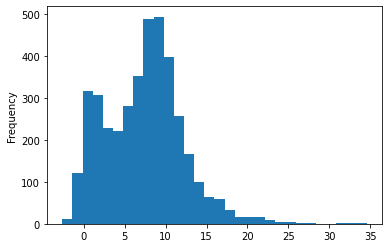

In [33]:
other_train.kurtosis_oxygen.plot.hist(bins=30)

<Axes: xlabel='kurtosis_oxygen', ylabel='Density'>

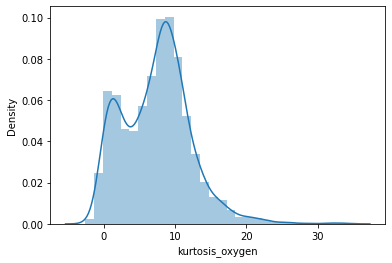

In [34]:
sns.distplot(other_train.kurtosis_oxygen, bins = 30)

skewness_glucose

In [35]:
print("skewness_glucose mode: ", (stats.mode(other_train.skewness_glucose, nan_policy='omit')[0][0]))

skewness_glucose mode:  -1.469010271


<Axes: ylabel='Frequency'>

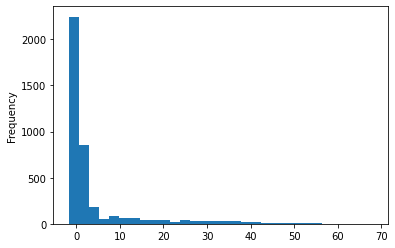

In [36]:
other_train.skewness_glucose.plot.hist(bins=30)

<Axes: xlabel='skewness_glucose', ylabel='Density'>

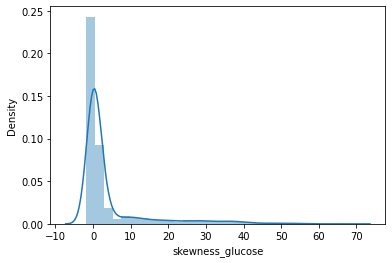

In [37]:
sns.distplot(other_train.skewness_glucose, bins = 30)

mean_glucose

In [38]:
print("mean_glucose mode: ", (stats.mode(other_train.mean_glucose, nan_policy='omit')[0][0]))

mean_glucose mode:  98.359375


<Axes: ylabel='Frequency'>

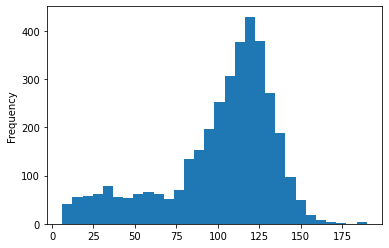

In [39]:
other_train.mean_glucose.plot.hist(bins=30)

<Axes: xlabel='mean_glucose', ylabel='Density'>

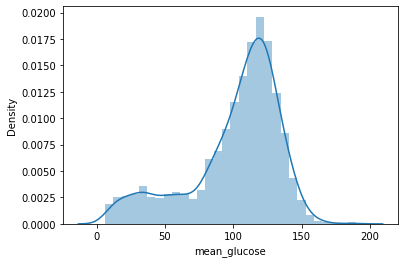

In [40]:
sns.distplot(other_train.mean_glucose, bins = 30)

std_oxygen

In [41]:
print("std_oxygen mode: ", (stats.mode(other_train.std_oxygen, nan_policy='omit')[0][0]))

std_oxygen mode:  9.561140874


<Axes: ylabel='Frequency'>

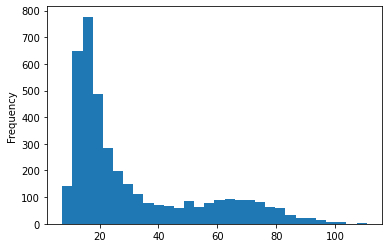

In [42]:
other_train.std_oxygen.plot.hist(bins=30)

<Axes: xlabel='std_oxygen', ylabel='Density'>

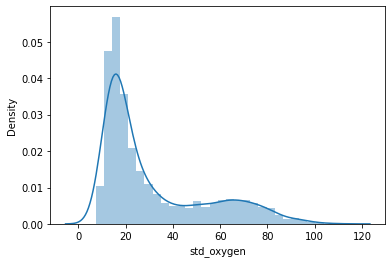

In [43]:
sns.distplot(other_train.std_oxygen, bins = 30)

skewness_oxygen

In [44]:
print("skewness_oxygen mode: ", (stats.mode(other_train.skewness_oxygen, nan_policy='omit')[0][0]))

skewness_oxygen mode:  -1.529394362


<Axes: ylabel='Frequency'>

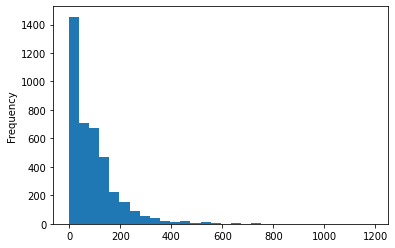

In [45]:
other_train.skewness_oxygen.plot.hist(bins=30)

<Axes: xlabel='skewness_oxygen', ylabel='Density'>

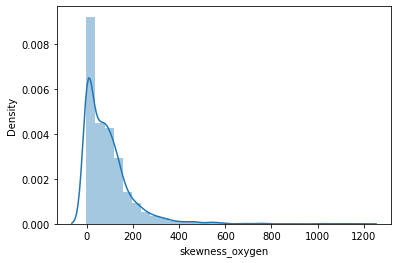

In [46]:
sns.distplot(other_train.skewness_oxygen, bins = 30)

kurtosis_glucose

In [47]:
print("kurtosis_glucose mode: ", (stats.mode(other_train.kurtosis_glucose, nan_policy='omit')[0][0]))

kurtosis_glucose mode:  -0.399218347


<Axes: ylabel='Frequency'>

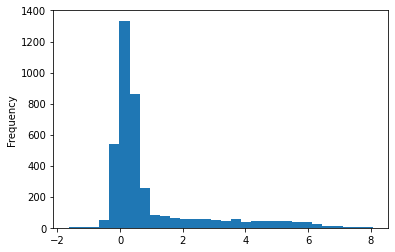

In [48]:
other_train.kurtosis_glucose.plot.hist(bins=30)

<Axes: xlabel='kurtosis_glucose', ylabel='Density'>

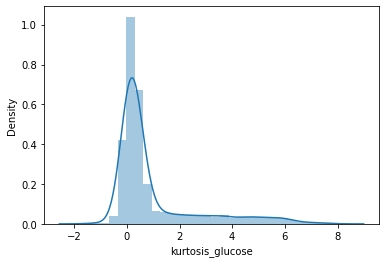

In [49]:
sns.distplot(other_train.kurtosis_glucose, bins = 30)

std_glucose

In [50]:
print("std_glucose mode: ", (stats.mode(other_train.std_glucose, nan_policy='omit')[0][0]))

std_glucose mode:  29.86770554


<Axes: ylabel='Frequency'>

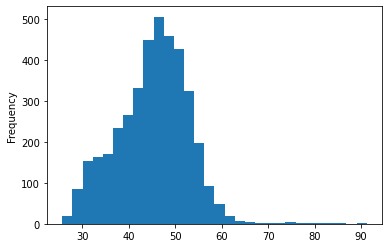

In [51]:
other_train.std_glucose.plot.hist(bins=30)

<Axes: xlabel='std_glucose', ylabel='Density'>

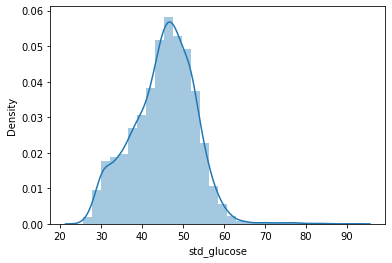

In [52]:
sns.distplot(other_train.std_glucose, bins = 30)

mean_oxygen

In [53]:
print("mean_oxygen mode: ", (stats.mode(other_train.mean_oxygen, nan_policy='omit')[0][0]))

mean_oxygen mode:  2.118729097


<Axes: ylabel='Frequency'>

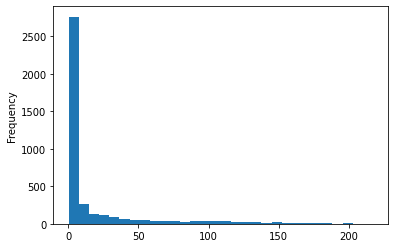

In [54]:
other_train.mean_oxygen.plot.hist(bins=30)

<Axes: xlabel='mean_oxygen', ylabel='Density'>

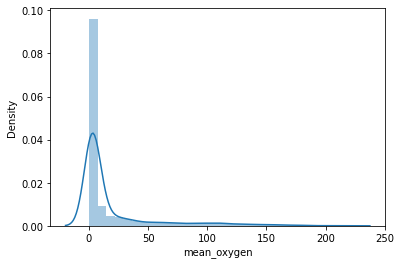

In [55]:
sns.distplot(other_train.mean_oxygen, bins = 30)

## One by one analysis (continuous) - other_train <a id='third_other_train'></a>

Bar and pie graphs for categorical attributes from other_train dataset. From each graph we can see unique values and numbers for each value from specific column.

<Axes: >

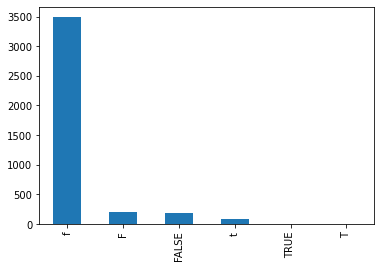

In [56]:
other_train['pregnant'].value_counts().plot(kind='bar')

<Axes: >

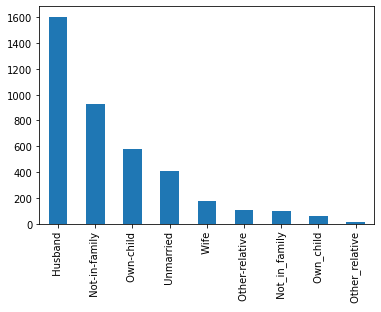

In [57]:
other_train['relationship'].value_counts().plot(kind='bar')

<Axes: >

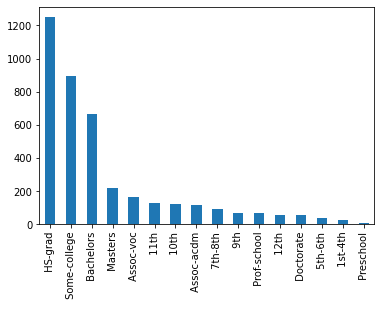

In [58]:
other_train['education'].value_counts().plot(kind='bar')

<Axes: ylabel='class'>

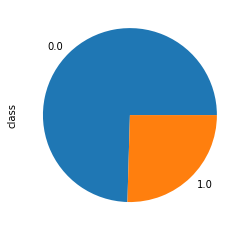

In [59]:
other_train['class'].value_counts().plot(kind='pie')

<Axes: ylabel='income'>

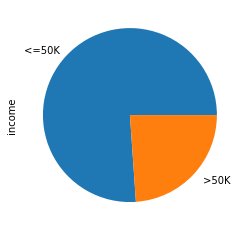

In [60]:
other_train['income'].value_counts().plot(kind='pie')

<Axes: >

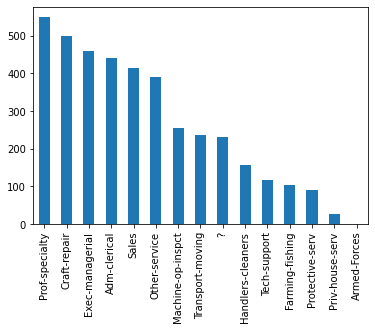

In [61]:
other_train['occupation'].value_counts().plot(kind='bar')

<Axes: >

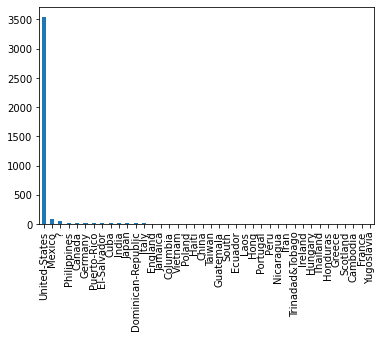

In [62]:
other_train['country'].value_counts().plot(kind='bar')

<Axes: >

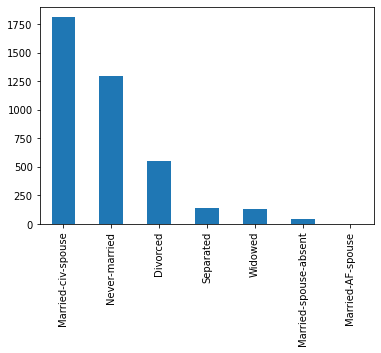

In [63]:
other_train['marital-status'].value_counts().plot(kind='bar')

<Axes: >

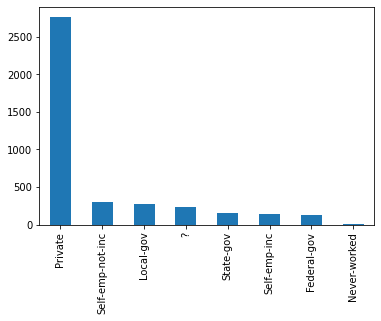

In [64]:
other_train['workclass'].value_counts().plot(kind='bar')

## One by one analysis (continuous) - personal_train <a id='second_personal_train'></a>

In [65]:
personal_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0.1   3933 non-null   int64 
 1   Unnamed: 0     3933 non-null   int64 
 2   name           3933 non-null   object
 3   age            3674 non-null   object
 4   sex            3933 non-null   object
 5   date_of_birth  3933 non-null   object
dtypes: int64(2), object(4)
memory usage: 184.5+ KB


We can see that attribute age is type of object, so let's change it to Int64

In [66]:
personal_train['age'] = pd.to_numeric(personal_train['age'], errors='coerce')
personal_train['age'] = personal_train['age'].astype('Int64')

In [67]:
personal_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0.1   3933 non-null   int64 
 1   Unnamed: 0     3933 non-null   int64 
 2   name           3933 non-null   object
 3   age            3540 non-null   Int64 
 4   sex            3933 non-null   object
 5   date_of_birth  3933 non-null   object
dtypes: Int64(1), int64(2), object(3)
memory usage: 188.3+ KB


From describe we can see for 'age' column value for mean, standard deviation, quartiles, min and max 

In [68]:
personal_train.describe()

Unnamed: 0.1   Unnamed: 0          age
count   3933.000000  3933.000000       3540.0
mean    1966.000000  1966.000000    36.673446
std     1135.503633  1135.503633  1671.961297
min        0.000000     0.000000      -8600.0
25%      983.000000   983.000000         43.0
50%     1966.000000  1966.000000         52.0
75%     2949.000000  2949.000000         61.0
max     3932.000000  3932.000000       8000.0

Median for age

In [69]:
personal_train.median()

Unnamed: 0.1    1966.0
Unnamed: 0      1966.0
age               52.0
dtype: float64

In [70]:
print("Most frequent value(mode) for column age: ", personal_train.age.mode()[0])

Most frequent value(mode) for column age:  53


Histogram with density graph of the probability distribution for column age.

<Axes: ylabel='Frequency'>

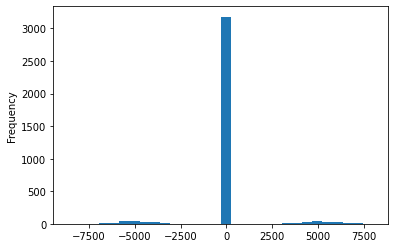

In [71]:
personal_train.age.plot.hist(bins=30)

<Axes: xlabel='age', ylabel='Density'>

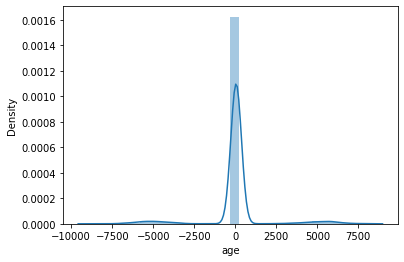

In [72]:
sns.distplot(personal_train.age.astype('float64'), bins = 30)

## One by one analysis (categorical) - personal_train <a id='third_personal_train'></a>

<Axes: ylabel='sex'>

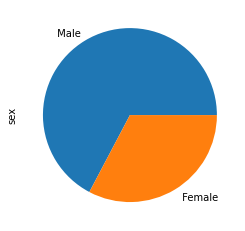

In [73]:
personal_train['sex'].value_counts().plot(kind='pie')

## Pair analysis - continuous <a id='pair_analysis_continuous'></a>

Correlation shows us the relationship between attributes, if the correlation is -1 it means an indirect correlation, 1 means a direct correlation, if the correlation value is 0 it means that the attributes are completely independent. We can notice that the dependence between the class attribute, which indicates whether the given user has the disease or not, and other attributes. We see that, according to the heatmap, we have a indirect correlation with mean_glucose and direct correlation with kurtosis_glucose.

<Axes: >

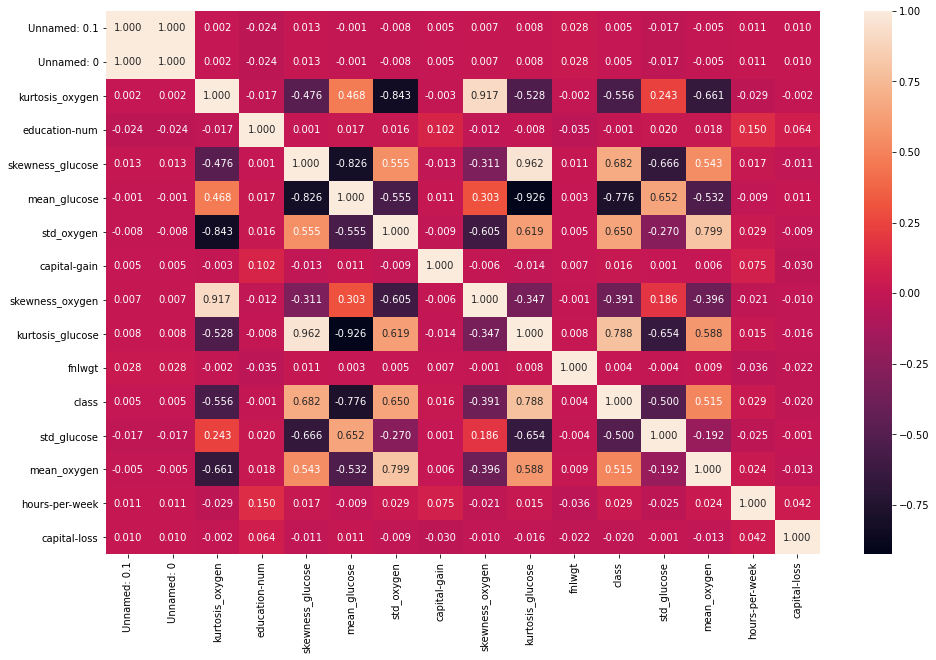

In [74]:
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(other_train.corr(), ax=ax, annot=True, fmt=".3f")

The following graph show the relationships between kurtosis_glucose and class attribute.

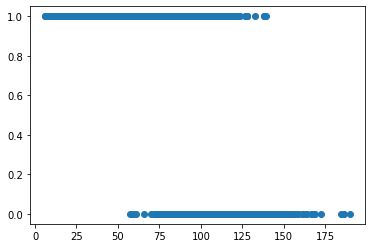

In [75]:
plt.scatter(other_train['mean_glucose'], other_train['class'])

The following graph show the relationships between mean_glucose and class attributes.

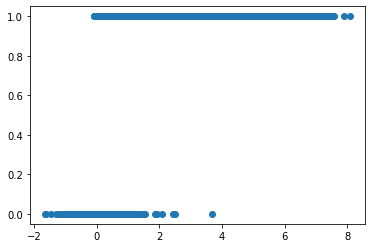

In [76]:
plt.scatter(other_train['kurtosis_glucose'], other_train['class'])

The following graph shows the type of employment depending on the mean_glucose value and class. We see that people who work in the Private sector have the most of this disease, but this graph is not very authoritative. Since we can see that the largest representation in the work sectors is for people who work in the Private sector, therefore this particular type of attribute can be dominant and can affect the graph.

<Axes: xlabel='mean_glucose', ylabel='class'>

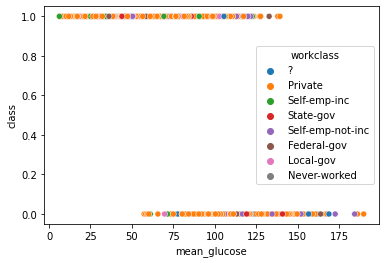

In [77]:
sns.scatterplot(other_train['mean_glucose'], other_train['class'], hue=other_train['workclass'])

In the following pairplot, we can see the dependencies of all pairs.

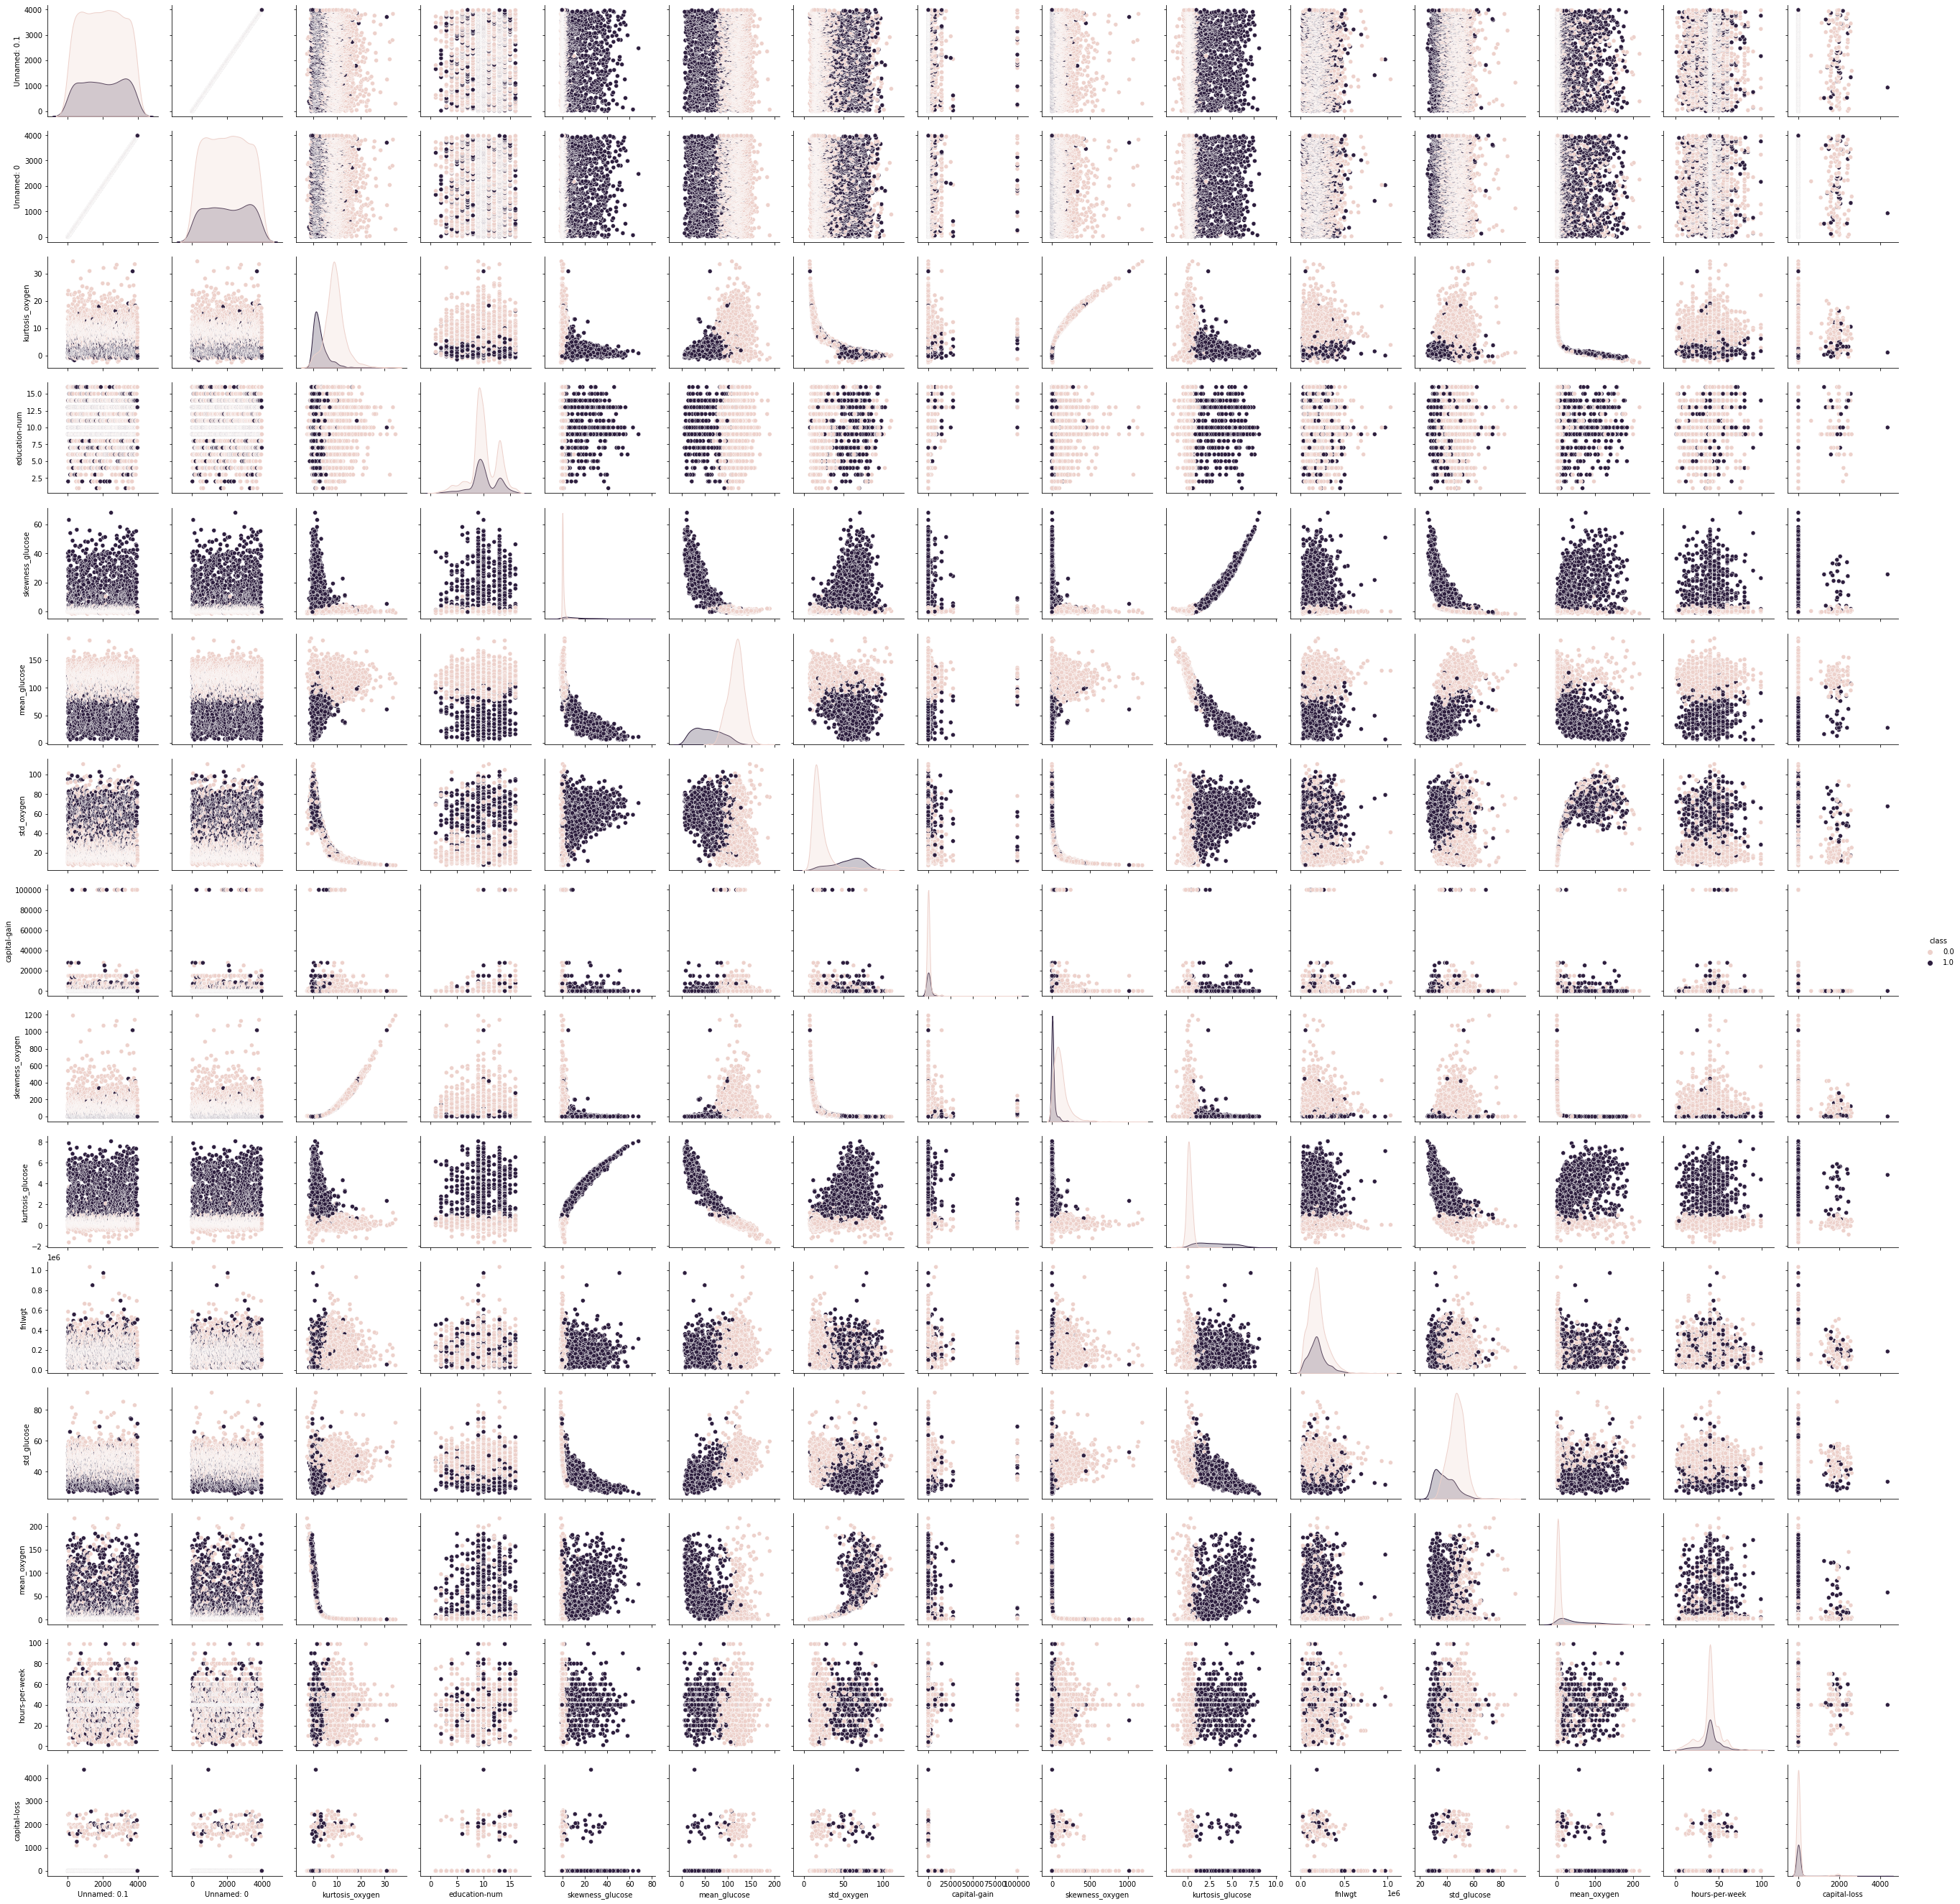

In [78]:
sns.pairplot(other_train, hue='class')

## Pair analysis - continous&categorical <a id='pair_analysis_continuous_categorical'></a>

As a category is the "class" attribute, which tells that whether the given user has or does not have a disease. From the following boxplot, we can see that people who have the disease also have lower mean_glucose values.

<Axes: xlabel='class', ylabel='mean_glucose'>

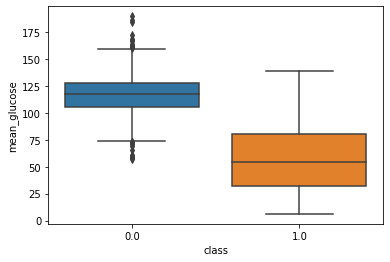

In [79]:
sns.boxplot('class', 'mean_glucose', data=other_train)

From the following boxplot, we can see that people who have the disease also have higher kurtosis_glucose values.

<Axes: xlabel='class', ylabel='kurtosis_glucose'>

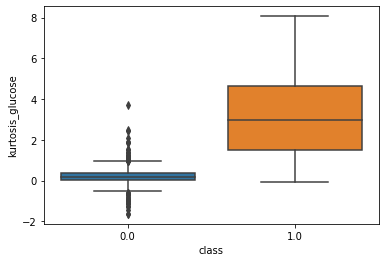

In [80]:
sns.boxplot('class', 'kurtosis_glucose', data=other_train)

## Pair analysis - categorical&categorical <a id='pair_analysis_categorical_categorical'></a>

The categories are chosen, "class" as in the previous graph and the second chosen category is "occupation", if the environment in which a person lives, works has any influence on the disease. We would say that "occupation" has not effect on the occurrence of the disease.

<Axes: xlabel='class', ylabel='occupation'>

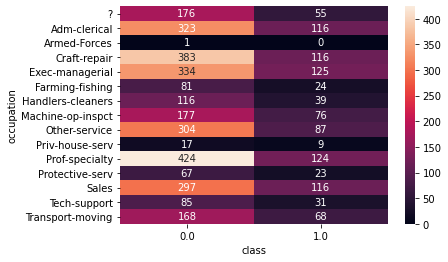

In [81]:
newclass = pd.crosstab(index=other_train["occupation"], columns=other_train["class"])
sns.heatmap(newclass, annot=True, fmt="d")

Relationship between glucose and oxygen in following graph with regression curves. 

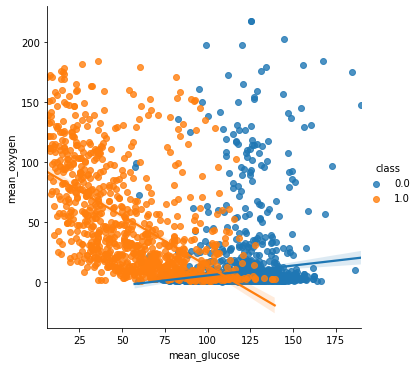

In [82]:
sns.lmplot(x="mean_glucose", y="mean_oxygen", hue="class", data=other_train)

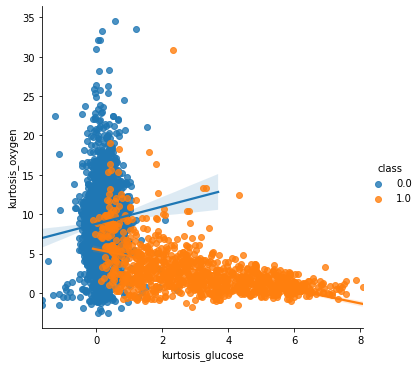

In [83]:
sns.lmplot(x="kurtosis_glucose", y="kurtosis_oxygen", hue="class", data=other_train)

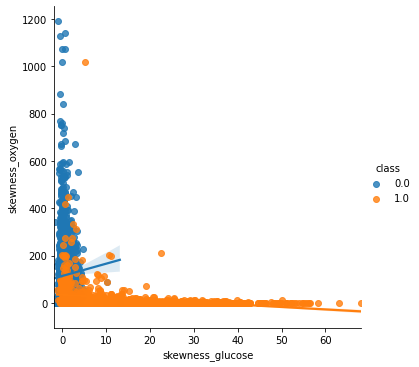

In [84]:
sns.lmplot(x="skewness_glucose", y="skewness_oxygen", hue="class", data=other_train)

## Hypotesis <a id='hypotesis'></a>

### 1. A person who has lower mean_glucose value ​​has a greater chance of suffering from the disease. <a id='hypotesis_1'></a>

<Axes: xlabel='class', ylabel='mean_glucose'>

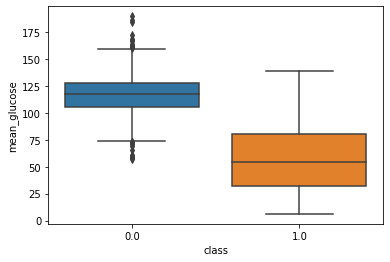

In [85]:
sns.boxplot('class', 'mean_glucose', data=other_train)

In [86]:
mean_glucose_0 = other_train.loc[other_train['class'] == 0, 'mean_glucose']
mean_glucose_1 = other_train.loc[other_train['class'] == 1, 'mean_glucose']

In [87]:
mean_glucose_0 = mean_glucose_0.dropna()
mean_glucose_1 = mean_glucose_1.dropna()

<Axes: xlabel='mean_glucose', ylabel='Density'>

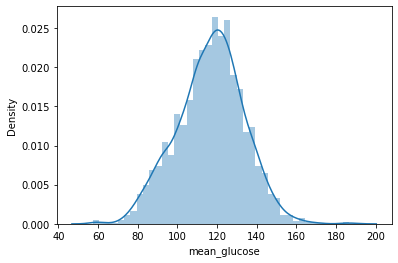

In [88]:
sns.distplot(mean_glucose_0)

<Axes: xlabel='mean_glucose'>

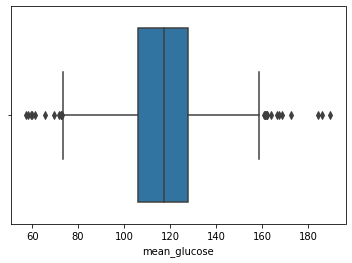

In [89]:
sns.boxplot(mean_glucose_0)

<Axes: xlabel='mean_glucose', ylabel='Density'>

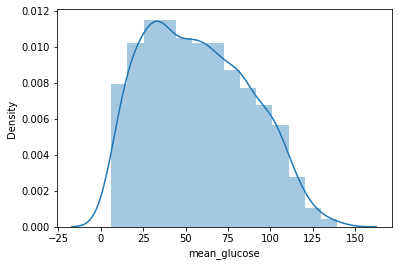

In [90]:
sns.distplot(mean_glucose_1)

<Axes: xlabel='mean_glucose'>

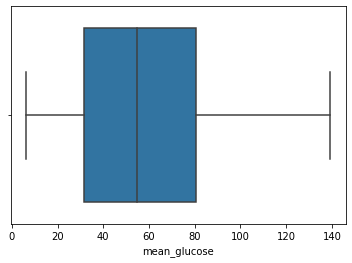

In [91]:
sns.boxplot(mean_glucose_1)

In [92]:
def identifyOutliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]

<Axes: xlabel='mean_glucose'>

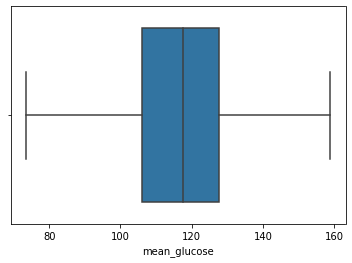

In [93]:
for i in range(6):
    mean_gluc_0 = identifyOutliers(mean_glucose_0)
    mean_glucose_0 = mean_glucose_0.drop(mean_gluc_0.index)

sns.boxplot(mean_glucose_0)

<Axes: xlabel='mean_glucose'>

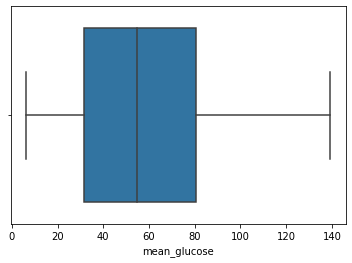

In [94]:
mean_gluc_1 = identifyOutliers(mean_glucose_1)
mean_glucose_1 = mean_glucose_1.drop(mean_gluc_1.index)

sns.boxplot(mean_glucose_1)

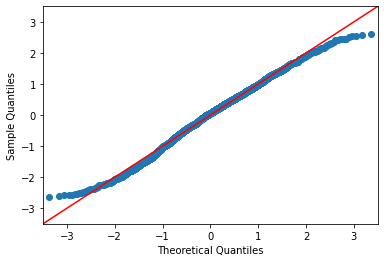

In [95]:
_ = sm.ProbPlot(mean_glucose_0, fit=True).qqplot(line='45')

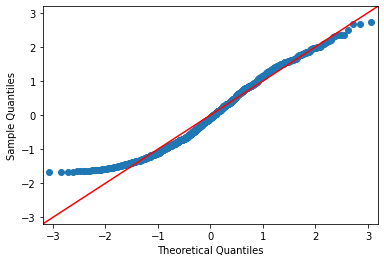

In [96]:
_ = sm.ProbPlot(mean_glucose_1, fit=True).qqplot(line='45')

For Shapiro and Levene, the alpha value is 0.05

In [97]:
stats.shapiro(mean_glucose_0)

ShapiroResult(statistic=0.9940618276596069, pvalue=8.021897812682255e-09)

The Shapiro-Wilk test showed us that p value for skewness_glucose_0 is < 0.05, it tells us that the distribution is different from normal distribution.

In [98]:
stats.shapiro(mean_glucose_1)

ShapiroResult(statistic=0.970327615737915, pvalue=1.0466773931946949e-12)

The Shapiro-Wilk test showed us that p value for skewness_glucose_1 is < 0.05, this indicates that the distribution is different from normal distribution.

In [99]:
stats.levene(mean_glucose_0, mean_glucose_1)

LeveneResult(statistic=755.4444806758906, pvalue=6.541190650534502e-151)

Based on the Levene test, we see that p value is lower than 0.05, which tells us that the data come from distributions with different variances. We failed to prove the assumptions, so we will use the non-parametric version of the Mann-Whitney U test.

In [100]:
stats.mannwhitneyu(mean_glucose_0, mean_glucose_1)

MannwhitneyuResult(statistic=2290426.0, pvalue=0.0)

From the result we see that p is equal to 0, i.e. that the difference in mean_glucose value for people who have the disease and those who do not is significant.

### 2. When a person has higher mean_oxygen value, he may not have a disease. <a id='hypotesis_2'></a>

<Axes: xlabel='class', ylabel='mean_oxygen'>

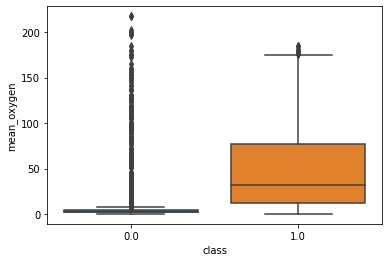

In [101]:
sns.boxplot('class', 'mean_oxygen', data=other_train)

In [102]:
oxygen_0 = other_train.loc[other_train['class'] == 0, 'mean_oxygen']
oxygen_1 = other_train.loc[other_train['class'] == 1, 'mean_oxygen']

In [103]:
oxygen_0 = oxygen_0.dropna()
oxygen_1 = oxygen_1.dropna()

<Axes: xlabel='mean_oxygen', ylabel='Density'>

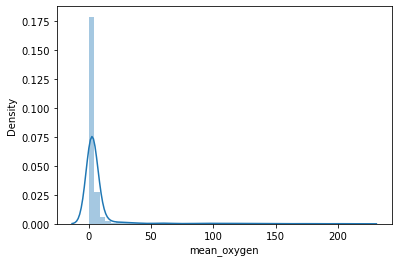

In [104]:
sns.distplot(oxygen_0)

<Axes: xlabel='mean_oxygen'>

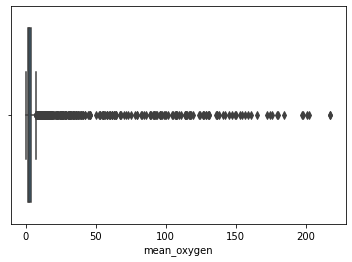

In [105]:
sns.boxplot(oxygen_0)

<Axes: xlabel='mean_oxygen', ylabel='Density'>

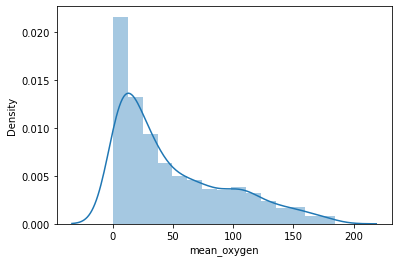

In [106]:
sns.distplot(oxygen_1)

<Axes: xlabel='mean_oxygen'>

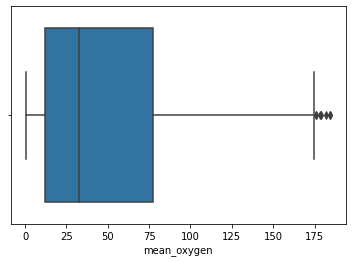

In [107]:
sns.boxplot(oxygen_1)

From the data we can see that it is necessary to remove outliers.

<Axes: xlabel='mean_oxygen'>

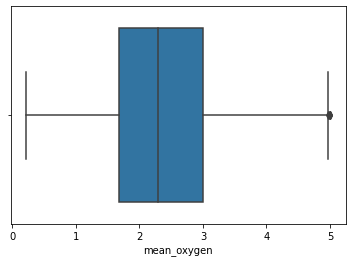

In [108]:
for i in range(7):
    oxy_0 = identifyOutliers(oxygen_0)
    oxygen_0 = oxygen_0.drop(oxy_0.index)

sns.boxplot(oxygen_0)

<Axes: xlabel='mean_oxygen'>

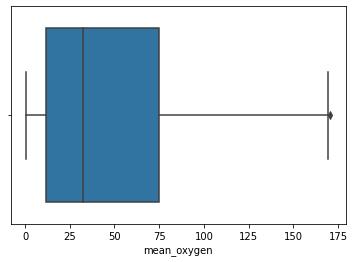

In [109]:
for i in range(3):
    oxy_1 = identifyOutliers(oxygen_1)
    oxygen_1 = oxygen_1.drop(oxy_1.index)

sns.boxplot(oxygen_1)

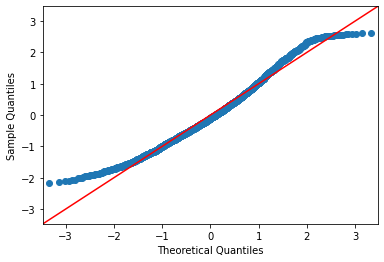

In [110]:
_ = sm.ProbPlot(oxygen_0, fit=True).qqplot(line='45')

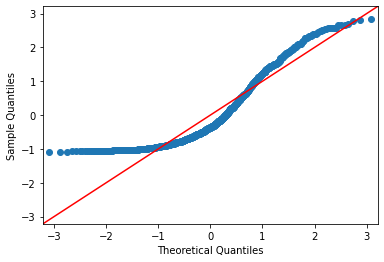

In [111]:
_ = sm.ProbPlot(oxygen_1, fit=True).qqplot(line='45')

For Shapiro and Levene, the alpha value is 0.05

In [112]:
stats.shapiro(oxygen_0)

ShapiroResult(statistic=0.9810813069343567, pvalue=3.390558075189942e-17)

The Shapiro-Wilk test showed us that p value for skewness_glucose_0 is < 0.05, it tells us that the distribution is different from normal distribution.

In [113]:
stats.shapiro(oxygen_1)

ShapiroResult(statistic=0.8767872452735901, pvalue=2.341881315975308e-27)

The Shapiro-Wilk test showed us that p value for skewness_glucose_1 is < 0.05, it tells us that the distribution is different from normal distribution.

In [114]:
stats.levene(oxygen_0, oxygen_1)

LeveneResult(statistic=2796.762672391599, pvalue=0.0)

Based on the Levene test, we see that p = 0, which tells us that the data come from distributions with different variances. We failed to prove the assumptions, so we will use the non-parametric version of the Mann-Whitney U test.

In [115]:
stats.mannwhitneyu(oxygen_0, oxygen_1)

MannwhitneyuResult(statistic=107654.0, pvalue=0.0)

From the result we see that p is equal to 0, i.e. that the difference in mean_oxygen value for people who have the disease and those who do not is significant.

## The problem in the data <a id='data_problem'></a>

During the analysis of the other_train data, the following problems were detected:

Following attributes contain NaN values:
 - column "pregnant" 
 - column "education-num" 
 - column "relationship"
 - column "capital-gain"
 - column "education"
 - column "class"
 - column "income"
 - column "hours-per-week"
 - column "capital-loss"
 - columns that contain information about oxygen and glucose

Column "personal-info", after breaking into individual columns, into 4 other columns(occcupation, country, marital-status, workclass) was found to contain NaN value


In [116]:
pd.isna(other_train).sum()

Unnamed: 0.1          0
Unnamed: 0            0
name                  0
address               0
kurtosis_oxygen      16
pregnant             14
education-num        13
relationship         15
skewness_glucose     16
mean_glucose        405
std_oxygen           17
capital-gain         14
skewness_oxygen      19
kurtosis_glucose     20
education            16
fnlwgt               12
class                12
std_glucose           8
income               12
mean_oxygen          14
hours-per-week       22
capital-loss         12
occupation           11
country              11
marital-status       11
workclass            11
dtype: int64

Columns "occupation", "country" and "workclass" contain NaN values, also question mark type values

In [117]:
other_train.loc[other_train['occupation'].isin(['?'])][:3]

Unnamed: 0.1  Unnamed: 0    name    address  kurtosis_oxygen pregnant  \
0              0           0   user0   address0        16.152882        f   
4              4           4   user4   address4         0.905511        f   
32            32          32  user32  address32         8.498830        f   

    education-num    relationship  skewness_glucose  mean_glucose  ...  class  \
0             9.0         Husband          0.179927    128.781250  ...    0.0   
4            13.0   Not-in-family         37.449172     16.539062  ...    1.0   
32           10.0       Own-child          1.507931     75.976562  ...    0.0   

    std_glucose  income  mean_oxygen hours-per-week  capital-loss  occupation  \
0     47.898483    >50K     1.098662           40.0           0.0           ?   
4     30.500743   <=50K    67.451505           50.0           0.0           ?   
32    42.614820   <=50K     2.452341           84.0           0.0           ?   

          country      marital-status  workclass  
0   United-States  Married-civ-spouse          ?  
4   United-States            Divorced          ?  
32  United-States       Never-married          ?  

[3 rows x 26 columns]

In [118]:
other_train.loc[other_train['country'].isin(['?'])][:3]

Unnamed: 0.1  Unnamed: 0     name     address  kurtosis_oxygen pregnant  \
248           248         248  user248  address248        10.577124    FALSE   
326           326         326  user326  address326         9.479700    FALSE   
379           379         379  user379  address379         1.972958        f   

     education-num relationship  skewness_glucose  mean_glucose  ...  class  \
248            9.0      Husband          0.587412    119.414062  ...    0.0   
326            9.0      Husband         -0.006883    150.828125  ...    0.0   
379           16.0      Husband         18.011655     53.789062  ...    1.0   

     std_glucose  income  mean_oxygen hours-per-week  capital-loss  \
248    49.237233   <=50K     2.122074           40.0           0.0   
326    52.606159   <=50K     2.373746           60.0           0.0   
379    30.062085    >50K    30.670569           72.0           0.0   

            occupation  country      marital-status     workclass  
248  Machine-op-inspct        ?  Married-civ-spouse       Private  
326   Transport-moving        ?  Married-civ-spouse  Self-emp-inc  
379     Prof-specialty        ?  Married-civ-spouse   Federal-gov  

[3 rows x 26 columns]

In [119]:
other_train.loc[other_train['workclass'].isin(['?'])][:3]

Unnamed: 0.1  Unnamed: 0    name    address  kurtosis_oxygen pregnant  \
0              0           0   user0   address0        16.152882        f   
4              4           4   user4   address4         0.905511        f   
32            32          32  user32  address32         8.498830        f   

    education-num    relationship  skewness_glucose  mean_glucose  ...  class  \
0             9.0         Husband          0.179927    128.781250  ...    0.0   
4            13.0   Not-in-family         37.449172     16.539062  ...    1.0   
32           10.0       Own-child          1.507931     75.976562  ...    0.0   

    std_glucose  income  mean_oxygen hours-per-week  capital-loss  occupation  \
0     47.898483    >50K     1.098662           40.0           0.0           ?   
4     30.500743   <=50K    67.451505           50.0           0.0           ?   
32    42.614820   <=50K     2.452341           84.0           0.0           ?   

          country      marital-status  workclass  
0   United-States  Married-civ-spouse          ?  
4   United-States            Divorced          ?  
32  United-States       Never-married          ?  

[3 rows x 26 columns]

Column "pregnant", the data is not uniform, it is written in uppercase or lowercase letters, it is written in one letter or five letters, and somewhere there are values ​​of NaN

In [120]:
other_train['pregnant'].unique()

array(['f', 'F', 'FALSE', 't', 'TRUE', nan, 'T'], dtype=object)

During the analysis of the personal_train data, the following problems were detected

The "age" column contains values like for example -1

In [121]:
personal_train.loc[personal_train['age'].isin([-1])]

Unnamed: 0.1  Unnamed: 0      name  age      sex        date_of_birth
390           390         390  user1333   -1   Female  2020-08-19 00:00:00

Column "date_of_birth" the data is not uniform

In [122]:
personal_train

Unnamed: 0.1  Unnamed: 0      name    age      sex        date_of_birth
0                0           0   user148  -5700   Female             62-10-15
1                1           1  user3128   <NA>     Male           1976-06-07
2                2           2  user2672     55   Female           1964-05-08
3                3           3   user784     54   Female  1965-07-27 00:00:00
4                4           4    user28     56     Male           1963-05-18
...            ...         ...       ...    ...      ...                  ...
3928          3928        3928   user727     51   Female           1968-09-24
3929          3929        3929   user798     41     Male           1977-11-08
3930          3930        3930  user3899     46     Male           1973-01-25
3931          3931        3931  user2240     27     Male           1992-04-28
3932          3932        3932  user3048     17     Male           2001-12-01

[3933 rows x 6 columns]

## Assumptions of solution <a id='assumptions'></a>

 - in each column that contains a question mark, replace it with the value NaN
 - replace -1(and other not logical number) with the value NaN in the age attribute of the personal_train dataset
 - rename the values ​​of certain attributes that indicate the same value to a uniform format 
 - remove duplicate records for names so that they appear only once in the dataset
 - connect other and personal datasets together
 - remove spaces

In [123]:
other_train.to_csv('data/other_train_analysis.csv', encoding='utf-8', index=False)
personal_train.to_csv('data/personal_train_analysis.csv', encoding='utf-8', index=False)